In [16]:
#!pip install numba
#!pip install pyproj

import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pyproj
import pandas as pd
#import xarray as xr
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
from numba import njit
#from glob import glob
import time
import cv2

In [17]:
mss_file = '/mnt/spaces/SSH/MSS/DTU21MSS_1min.mss.nc'
mss_file = 'DTU21MSS_1min.mss.nc'
cam_file = '20220718_144142_328_0689.jpg'
#cam_file = '20220718_153738_364_1521.jpg'
apx_file = '/mnt/spaces/Campaigns/2022_PS131_ATWAICE/Helicopter/ir-camera/gpsins-ascii/20220718_02_PS131_Heli-PS/insgps-ps131-pospac_export_gnssprim_20220718_02.txt'
apx_file = 'insgps-ps131-pospac_export_gnssprim_20220718_02.txt'
#save_nc_file = '/Users/gspreen/Seafile/Gunnar/Campaigns/2022-07_PS131_ATWAICE/Data/ir-camera/Flight09_220718_142920/IRdata_ATWAICE_processed_220718_142920.nc'

In [18]:
def get_corrds(lon,lat,lon0,lat0):
    proj_dict_new = dict(proj='stere', 
                         lat_0=lat0,
                         lat_ts=lat0,
                         lon_0=lon0,
                         k=1,
                         x_0=0,
                         y_0=0,
                         ellps='WGS84',
                         units='m')
    p = pyproj.Proj(proj_dict_new)
    
    return p(lon,lat)


def get_mss(lat, lon, mss, lon_mss, lat_mss):
    """
    Loading Mean sea surface height data. Calculating values along the flight track.
    Input
        - lon, lat: numpy.ndarray
        - mss, lon_mss, lat_mss: pd.Series
    Output
        - mss_ts: list
    """
    
    # getting index of closest pixel of mss data to flight track
    mss_ts = []
    ix_lat = np.abs(lat_mss-lat).argmin()
    ix_lon = np.abs(lon_mss-lon).argmin()
    mss_ts.append(mss[ix_lat,ix_lon])
    
    return mss_ts[0]

In [19]:
#@njit
def rotx(r):
    Rr = np.array([[1.0, 0.0, 0.0, 0.0],[0.0, np.cos(r), -np.sin(r), 0.0],[0.0, np.sin(r), np.cos(r), 0.0],[0.0, 0.0, 0.0, 1.0]])
    return Rr

#@njit
def roty(p):
    Rp = np.array([[np.cos(p), 0.0, np.sin(p), 0.0],[0.0, 1.0, 0.0, 0.0],[-np.sin(p), 0.0, np.cos(p), 0.0],[0.0, 0.0, 0.0, 1.0]])
    return Rp

#@njit
def rotz(y):
    Ry = np.array([[np.cos(y), -np.sin(y), 0.0, 0.0],[np.sin(y), np.cos(y), 0.0, 0.0],[0.0, 0.0, 1.0, 0.0],[0.0, 0.0, 0.0, 1.0]])
    return Ry

#@njit
def pix_loc(img, roll,pitch,yaw,height,xc,yc,p_off,ho,x_coord,y_coord):

    ro,po,yo,f,k1 = p_off

    # Rotation matrix
    pxrot=rotx(np.deg2rad(roll)) 
    pyrot=roty(np.deg2rad(pitch))
    pzrot=rotz(np.deg2rad(yaw))

    # Rotation
    crot=(pxrot@rotx(np.deg2rad(ro)))@(pyrot@roty(np.deg2rad(po)))@(pzrot@rotz(np.deg2rad(yo)))
    Rc=crot[0:3,0:3] # rotation  matrix
    
    # New camera location
    camera_location = np.array([xc,yc,height-ho]) 
   
    for yi in range(img.shape[1]):
        for xi in range(img.shape[0]):

            # normalization pixel positions
            x_d = (xi-240)/f
            y_d = (yi-320)/f

            # radial distortion factor
            rsqrd = x_d**2 + y_d**2
            r_d = 1 + k1*rsqrd 

            # undistorted pixel positions
            x_n = x_d/r_d
            y_n = y_d/r_d
            
            # Rotate viewing farme to world frame
            ray_tmp = np.array([x_n, y_n, 1.])   
            ray = Rc.T@ray_tmp     
#             ray = mul(Rc.T,ray_tmp)
            k = -camera_location[-1]/ray[-1]

            # new point of intersection coordinates
            pt = camera_location + k*ray
            
            # write point to array - coordinates of full image
            x_coord[xi,yi]=pt[0]
            y_coord[xi,yi]=pt[1]
            
    return x_coord,y_coord

In [20]:
print('Load data:')

img = cv2.imread(cam_file, 0)
#img = cv2.resize(img, (640, 480))

# time
#date_str = cam_file[:15]
#starttime = datetime.strptime(date_str, '%y%m%d_%H%M%S')
#date = datetime.strptime(date_str[:8], '%y%m%d')
#init = (starttime-date).total_seconds()
#ttt = init + .25 * np.arange(0,len(cam_data.time))

# images with new time
#cam_data = cam_data.assign_
#coords(time=ttt)
#temps = cam_data.temps #[:1000] # <------------------ONLY SUBSET OF DATA, DEFINE RANGE HERE (for reducing required memory)
#temps = temps[::nth] # here only every fourth image will be taken/reduced frequency (for reducing required memory)

# slicing starts with first element, so temps[0] == cam_data[0]

# radial image gradient
#gradient_array = image_gradient(temps.data)

Load data:


In [21]:
df_apx = pd.read_csv(apx_file,skiprows=27,sep='\s+', header=None)
header = pd.read_csv(apx_file, header=23,nrows=0,sep=',\s', engine='python')
df_apx.columns=list(header)
df_apx['TIME']=(df_apx['TIME']%86400)
df_apx = df_apx.set_index('TIME')

# Interpolators for Applanix variables (to be fitted with Camera times)
int_lon = interp1d(df_apx.index, df_apx.LONGITUDE)
int_lat = interp1d(df_apx.index, df_apx.LATITUDE)
int_roll = interp1d(df_apx.index, df_apx.ROLL)
int_pitch = interp1d(df_apx.index, df_apx.PITCH)
int_heading = interp1d(df_apx.index, df_apx.HEADING)
int_height = interp1d(df_apx.index, df_apx['ELLIPSOID HEIGHT'])

mlon = float(np.mean(df_apx.LONGITUDE))
mlat = float(np.mean(df_apx.LATITUDE))

# mean sea surface height
data_mss = Dataset(mss_file)
mss = data_mss.variables['mss'][:]
lat_mss=data_mss.variables['lat'][:]
lon_mss=data_mss.variables['lon'][:]

In [22]:
time_str = cam_file[9:15]  # Replace this with your HHMMSS time representation

# Extract hours, minutes, and seconds from the string
hours = int(time_str[:2])
minutes = int(time_str[2:4])
seconds = int(time_str[4:])

# Convert HHMMSS format to total seconds
total_seconds = hours * 3600 + minutes * 60 + seconds

print("Total seconds:", total_seconds)

Total seconds: 52902


In [23]:
print(df_apx.index)

Float64Index([       52493.00266,        52493.00766,        52493.01267,
                     52493.01767, 52493.022670000006,  52493.02767000001,
              52493.032669999986,  52493.03766999999, 52493.042669999995,
                     52493.04767,
              ...
               57481.95709000001, 57481.962089999986,  57481.96708999999,
              57481.972089999996,  57481.97709999999, 57481.982099999994,
                      57481.9871,         57481.9921,  57481.99710000001,
                     57482.00211],
             dtype='float64', name='TIME', length=997571)


Processing:
(2600, 3908)
Image georef ...
52902
(2600, 3908)
(2600, 3908)
(2600, 3908)


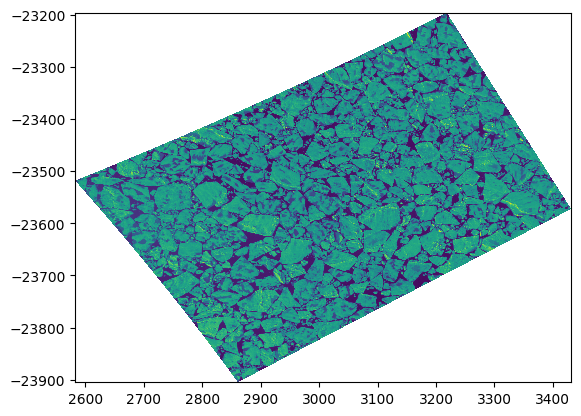

0 values are not in interpolation range
2 minutes
Save NetCDF:
0 processed images included.


In [15]:
print('Processing:')

img_ix_list=[];img_list=[];xd_list=[];yd_list=[]
time_list=[];lon_list=[];lat_list=[]
roll_list=[];pitch_list=[];mod_head_list=[];
alti_list=[];mss_list=[]

c=0
emissivity=0.996
x_coord=np.zeros(img.shape);y_coord=np.zeros(img.shape)
print(x_coord.shape)
#x_coord=np.zeros((480,640));y_coord=np.zeros((480,640))

start=time.time()
print('Image georef ...')

ttime=float(cam_file[9:15])
ttime = total_seconds

print(ttime)

#img=(temps[i].values)/100
#img = img[::-1,::-1] # <--------- Here image orientation is adapted
#img = img[:,:] # <--------- Here image orientation is adapted
#img = img[::,::]

lon=float(int_lon(ttime))
lat=float(int_lat(ttime))
roll=float(int_roll(ttime))
pitch=float(int_pitch(ttime))
heading=float(int_heading(ttime))
altitude=float(int_height(ttime))

# heading from [0,360] to [-180,180]
mod_head = heading + (mlon-lon)
if mod_head<-180: 
    mod_head+=360
elif mod_head>180: 
    mod_head-=360
else:
    pass 

# correction of image gradient
#img = img/gradient_array.data
#img = img/emissivity

# Mean sea surface height at location for height correction
p_mss = get_mss(lat, lon, mss, lon_mss, lat_mss)

# Stereographic x,y coordinates in meter
xloc,yloc=get_corrds(lon,lat,mlon,mlat)

# image pixels
voff=(0.458456,0.134936,88.3343,1949.31787,-0.018947) # Fit parameter for MOSAiC Leg 1 mit (roll,pitch,yaw,f,k)
xd,yd = pix_loc(img, roll,-pitch,mod_head,altitude,xloc,yloc,voff,p_mss,x_coord,y_coord)

# object assignment, because otherwise redirected and the same
xd_tmp = xd.copy() 
yd_tmp = yd.copy()

print(xd.shape)
print(yd.shape)
print(img.shape)

plt.pcolormesh(xd,yd,img)
plt.savefig('test.png')
plt.show()

print(str(c)+' values are not in interpolation range')
end = time.time()
print(str(round((end-start)/60))+' minutes')
print('Save NetCDF:')
print(str(len(img_list))+' processed images included.')


In [ ]:
fig, ax = plt.subplots()

ax = plt.pcolormesh(xd,yd,img)
ax.set_xlim(2590,)

plt.savefig('test.png')
plt.show()

print(str(c)+' values are not in interpolation range')
end = time.time()
print(str(round((end-start)/60))+' minutes')
print('Save NetCDF:')
print(str(len(img_list))+' processed images included.')

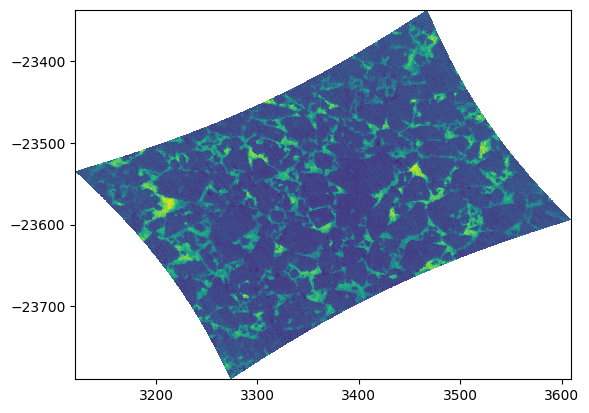

In [63]:
import netCDF4

ir = netCDF4.Dataset('IRdata_ATWAICE_processed_220718_142920.nc')

temp = ir.variables['Ts'][408]
x = ir.variables['xd'][408]
y = ir.variables['yd'][408]

plt.pcolormesh(x,y,temp)
plt.savefig('test_ir.png')
plt.show()

dict_keys(['time', 'latitude', 'longitude', 'altitude', 'speed', 'course', 'hdop', 'temps'])
52902.0


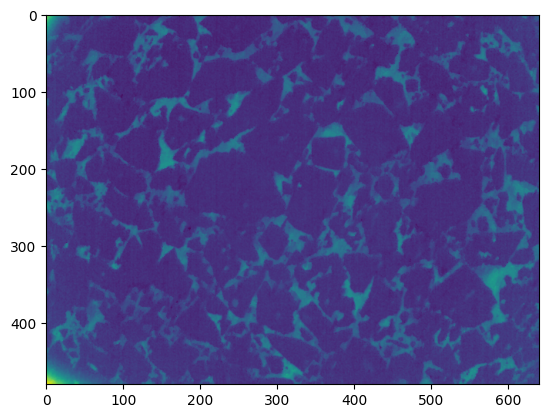

In [17]:
import netCDF4
import matplotlib.pyplot as plt

ir = netCDF4.Dataset('IRdata_ATWAICE_220718_142920.nc')

print(ir.variables.keys())

print(ir.variables['time'][2969])

temp = ir.variables['temps'][2969]
#x = ir.variables['xd'][408]
#y = ir.variables['yd'][408]

plt.imshow(temp)

#plt.pcolormesh(x,y,temp)
#plt.savefig('test_ir.png')
plt.show()